In [1]:
import time
# compute
import numpy as np
# flow matching
import torch
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import *
# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d

In [2]:
device = 'cuda'

In [3]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

In [4]:
def plot_trajectories1(trajs, colors, bg_centers, lifting_traj = 0, landing_traj = 3,  ax = None, n = 512):
    """Plot trajectories of some selected samples."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": "3d"})
    # t = 1
    for idx, (traj, color,bg_center) in enumerate(zip(trajs, colors, bg_centers)):
        # background
        square = patches.Rectangle(bg_center, .5, .5, edgecolor=color, facecolor=color, alpha=0.2, zorder = 0)
        ax.add_patch(square)
        art3d.pathpatch_2d_to_3d(square, z=1, zdir="z")
        if idx in [lifting_traj, landing_traj]:
            # traj
            ax.scatter(traj[:, :n, 0], traj[:, :n, 1], np.linspace(0, 1, traj.shape[0])[:, None], s=1, alpha=0.1, c="olive" if idx == landing_traj else "cyan", zorder = 1)
            # points
            ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], 1, s=10, alpha=1, c=color if idx == landing_traj else 'w', edgecolors=color, zorder = 2)

    # t = 0
    # background
    square = patches.Rectangle((-.5, -.5), 1, 1, edgecolor='black', facecolor='black', alpha=0.08, zorder = 0)
    ax.add_patch(square)
    art3d.pathpatch_2d_to_3d(square, z=0, zdir="z")
    # points
    ax.scatter(traj[0,:n, 0], traj[0, :n, 1], 0, s=10, alpha=0.8, c='black', zorder = 2)

    ax.invert_zaxis()
    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])
    ax.set_zlim([1., 0.])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    return ax

def plot_trajectories2(lift_trajs, land_trajs, colors, bg_centers, ax = None):
    """Plot trajectories of some selected samples."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": "3d"})
    # t = 1
    # background
    for idx, (color,bg_center) in enumerate(zip(colors, bg_centers)):
        # t = 1
        square = patches.Rectangle(bg_center, .5, .5, edgecolor=color, facecolor=color, alpha=0.2, zorder = 0)
        ax.add_patch(square)
        art3d.pathpatch_2d_to_3d(square, z=1, zdir="z")
        # t = 0
        square = patches.Rectangle((-.5, -.5), 1, 1, edgecolor='black', facecolor='black', alpha=0.08, zorder = 0)
        ax.add_patch(square)
        art3d.pathpatch_2d_to_3d(square, z=0, zdir="z")
        
    # traj
    for lift_traj, land_traj in zip(lift_trajs, land_trajs):
        ax.scatter(lift_traj[:, :, 0], lift_traj[:, :, 1], np.linspace(1, 0, lift_traj.shape[0])[:, None], s=1, alpha=0.1, c="cyan", zorder = 1)
        ax.scatter(land_traj[:, :, 0], land_traj[:, :, 1], np.linspace(0, 1, land_traj.shape[0])[:, None], s=1, alpha=0.1, c="olive", zorder = 1)
    # points
    ax.scatter(land_trajs[-1][-1, :, 0], land_trajs[-1][-1, :, 1], 1, s=50, alpha=1., c=colors[:lift_traj.shape[1]], zorder=2)
    ax.scatter(lift_trajs[0][0, :, 0], lift_trajs[0][0, :, 1], 1, s=50, alpha=1, edgecolors =colors[:lift_traj.shape[1]], c='w', zorder=2)
    
    ax.invert_zaxis()
    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])
    ax.set_zlim([1., 0.])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    return ax

def plot_trajectories3(lift_trajs, land_trajs, colors, bg_centers, z_lower=0.8, target_points = None, ax = None):
    """Plot trajectories of some selected samples."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": "3d"})
    # plot background
    for color,bg_center in zip(colors, bg_centers):
        square = patches.Rectangle(bg_center, .5, .5, edgecolor=color, facecolor=color, alpha=0.2, zorder = 0)
        ax.add_patch(square)
        art3d.pathpatch_2d_to_3d(square, z=1., zdir="z")
        square = patches.Rectangle(bg_center, .5, .5, edgecolor=color, facecolor=color, alpha=0.08, zorder = 0)
        ax.add_patch(square)
        art3d.pathpatch_2d_to_3d(square, z=z_lower, zdir="z")
    # plot trajs
    for i, (lift_traj, land_traj) in enumerate(zip(reversed(lift_trajs), reversed(land_trajs))):
        ax.scatter(lift_traj[:, :, 0], lift_traj[:, :, 1], np.linspace(1., z_lower, lift_traj.shape[0])[:, None], alpha=0.1, c= 'cyan', s = 1, zorder=1)
        ax.scatter(land_traj[:, :, 0], land_traj[:, :, 1], np.linspace(z_lower, 1., land_traj.shape[0])[:, None], alpha=0.1, c= 'olive', s= 1, zorder=1)
        if i > 0:
            ax.scatter(land_traj[-1, :, 0], land_traj[-1, :, 1], 1, alpha=1., c= colors, s= 30, marker='x', zorder=1)

    # plot target
    start_point = lift_trajs[0][0, -1]
    for p in target_points:
        line = torch.stack([p, start_point], dim = 0)
        ax.plot(line[:, 0], line[:, 1], 1, c = 'gray', ls = ':')

    # plot points
    ax.scatter(lift_trajs[0][0, :, 0], lift_trajs[0][0, :, 1], 1, s= 50, alpha=1., edgecolors =colors[:lift_traj.shape[1]], c='w', zorder=2)
    ax.scatter(land_trajs[-1][-1, :, 0], land_trajs[-1][-1, :, 1], 1, s= 50, alpha=1., c =colors[:lift_traj.shape[1]], zorder=2)

    ax.invert_zaxis()
    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])
    ax.set_zlim([1., 0.])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    return ax


def plot_trajectories4(lift_trajs, land_trajs, colors, bg_centers, z_lower=0.8,  target_points = None, target_points2 = None, ax = None):
    """Plot trajectories of some selected samples."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": "3d"})
    # plot background
    for color,bg_center in zip(colors, bg_centers):
        square = patches.Rectangle(bg_center, .5, .5, edgecolor=color, facecolor=color, alpha=0.1, zorder = 0)
        ax.add_patch(square)
    # plot trajs
    for i, (lift_traj, land_traj) in enumerate(zip(reversed(lift_trajs), reversed(land_trajs))):
        ax.scatter(lift_traj[:, :, 0], lift_traj[:, :, 1], alpha=0.1, c= 'cyan', s = 2, zorder=1)
        ax.scatter(land_traj[:, :, 0], land_traj[:, :, 1], alpha=0.1, c= 'olive', s= 2, zorder=1)
        if i > 0:
            ax.scatter(land_traj[-1, :, 0], land_traj[-1, :, 1], alpha=1., c= colors, s= 60, marker='x', zorder=1)

    # plot target
    start_point = lift_trajs[0][0, -1]
    for p in target_points:
        line = torch.stack([p, start_point], dim = 0)
        ax.plot(line[:, 0], line[:, 1], c = 'gray', ls = '--')
    start_point = land_trajs[-1][-1, :]
    for p in start_point:
        line = torch.stack([target_points2[0], p], dim = 0)
        ax.plot(line[:, 0], line[:, 1], c = 'gray', ls = ':')
    
    # plot points
    ax.scatter(lift_trajs[0][0, :, 0], lift_trajs[0][0, :, 1], s= 100, alpha=1., edgecolors =colors[:lift_traj.shape[1]], c='w', zorder=2)
    ax.scatter(land_trajs[-1][-1, :, 0], land_trajs[-1][-1, :, 1], s= 200, alpha=1., c =colors[:lift_traj.shape[1]], zorder=2)

    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])
    return ax

def plot_trajectories5(lift_trajs, land_trajs, colors, bg_centers, ax = None):
    """Plot trajectories of some selected samples."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": "3d"})
    # plot background
    for color,bg_center in zip(colors, bg_centers):
        square = patches.Rectangle(bg_center, .5, .5, edgecolor=color, facecolor=color, alpha=0.1, zorder = 0)
        ax.add_patch(square)
    # plot trajs
    for i, (lift_traj, land_traj) in enumerate(zip(reversed(lift_trajs), reversed(land_trajs))):
        ax.scatter(lift_traj[:, :, 0], lift_traj[:, :, 1], alpha=0.1, c= 'cyan', s = 2, zorder=1)
        ax.scatter(land_traj[:, :, 0], land_traj[:, :, 1], alpha=0.1, c= 'olive', s= 2, zorder=1)
        if i > 0:
            ax.scatter(land_traj[-1, :, 0], land_traj[-1, :, 1], alpha=1., c= colors, s= 60, marker='+', zorder=1)

    # plot points
    ax.scatter(land_trajs[-1][-1, :, 0], land_trajs[-1][-1, :, 1], s= 200, alpha=1., c =colors[:lift_traj.shape[1]], zorder=2, marker = 'v')

    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    return ax

In [5]:
def sample_square(n):
    return torch.cat([torch.rand(n, 1).float() - 0.5, torch.rand(n, 1).float() - 0.5], dim = 1)

def classifier(square):
    """
    x : (b, c)
    """
    label = torch.zeros(square.size(0), 1, dtype=int)
    label[((square[:, 0]>0.) & (square[:, 1]>0.))] = 3.
    label[((square[:, 0]>0.) & (square[:, 1]<0.))] = 2.
    label[((square[:, 0]<0.) & (square[:, 1]>0.))] = 1.
    label[((square[:, 0]<0.) & (square[:, 1]<0.))] = 0.
    return label

def sample_square_partition(n):
    square = sample_square(n)
    label = classifier(square)
    return square, label

def sample_square_selection(n, s):
    data, label = sample_square_partition(n)
    data = data[label[:, 0] == s]
    label = label[label[:, 0] == s]
    return data, label

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False, cond=False, cond_dim = None):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        if cond and cond_dim is None:
            cond_dim = 1
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0) + (cond_dim if cond else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
sigma = 0.
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True, cond=True, cond_dim = 1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(30000):
    optimizer.zero_grad()

    x0 = sample_square(batch_size).to(device)
    x1, label = sample_square_partition(batch_size)
    x1 = x1.to(device)
    label = label.to(device)
    t = torch.rand(x0.shape[0]).type_as(x0)
    
    xt = sample_conditional_pt(x0, x1, t, sigma=sigma)
    ut = compute_conditional_vector_field(x0, x1)

    vt = model(torch.cat([xt, t[:, None], label], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

5000: loss 0.059 time 17.41
10000: loss 0.060 time 17.80
15000: loss 0.072 time 17.59
20000: loss 0.060 time 17.04
25000: loss 0.072 time 17.79
30000: loss 0.067 time 18.37


In [8]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model, c, step_size= 1.):
        super().__init__()
        self.model = model
        self.c = c
        self.step_size = step_size

    def forward(self, t, x, *args, **kwargs):
        return self.step_size * self.model(torch.cat([x, t.repeat(x.shape[0]).to(x.device)[:, None], self.c.to(x.device)], 1))
        
@torch.no_grad()
def progressive_leap(model, source_points, classifier, target_y, lift_stepsize = 0.1, land_stepsize=0.1, max_itr = 10, n_steps = 10, t_lower = 0.):
    traj_lift_list = []
    traj_land_list = []
    lift_start_points = source_points
    for _ in range(max_itr):
        # lifting transport
        source_y = classifier(lift_start_points)
        node = NeuralODE(
            torch_wrapper(model, source_y, step_size=lift_stepsize), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        traj_lift = node.trajectory(
            lift_start_points,
            t_span=torch.linspace(1., t_lower, n_steps),
        )
        traj_lift_list.append(traj_lift)
        # landing transport
        land_start_points = traj_lift[-1]
        node = NeuralODE(
            torch_wrapper(model, target_y, step_size = land_stepsize), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        traj_land = node.trajectory(
            land_start_points,
            t_span=torch.linspace(t_lower, 1., n_steps),
        )
        traj_land_list.append(traj_land)
        lift_start_points = traj_land[-1]
    return traj_lift_list, traj_land_list

In [9]:
test_x = sample_square(512).to(device)
traj_r_list = []
for test_y_label in torch.arange(4):
    test_y = torch.ones(test_x.shape[0], 1) * test_y_label
    test_y = test_y.to(device)
    node = NeuralODE(
        torch_wrapper(model, test_y).to(device), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            test_x,
            t_span=torch.linspace(0, 1, 100),
        )
    traj_r_list.append(traj)
traj_r_list = list(map(lambda x: x.cpu(), traj_r_list))

In [10]:
init_centers = torch.tensor([[-.25, -.25], [-.25, .25], [.25, -.25], [.25, .25]]).to(device)
# init_residuals = ((torch.rand(1, 2) - .5) / 2.).repeat(4, 1).to(device)
init_residuals = torch.tensor([[-0.1, 0.05]]).repeat(4, 1).to(device)
start_points = init_centers + init_residuals
target_y = torch.ones(start_points.shape[0], 1).to(device) * 3.

In [11]:
t_lower1 = 0.
step_size1 = 1.
n_steps1 = 100
n_itr1 = 1

traj_lift_list1, traj_land_list1 = progressive_leap(
    model, start_points, classifier, target_y, 
    lift_stepsize = step_size1, land_stepsize=step_size1, 
    max_itr = n_itr1, n_steps=n_steps1, t_lower=t_lower1
)
traj_lift_list1 = list(map(lambda x: x.cpu(), traj_lift_list1))
traj_land_list1 = list(map(lambda x: x.cpu(), traj_land_list1))

In [12]:
t_lower2 = 0.
n_steps2 = 100
n_itr2 = 1
step_size2 = 1.

traj_lift_list2, traj_land_list2 = progressive_leap(
    model, start_points.detach(), classifier, target_y, 
    lift_stepsize = 0., land_stepsize=step_size2, 
    max_itr = n_itr2, n_steps=n_steps2, t_lower=t_lower2
)
traj_lift_list2 = list(map(lambda x: x.cpu(), traj_lift_list2))
traj_land_list2 = list(map(lambda x: x.cpu(), traj_land_list2))

In [13]:
t_lower3 = 0.
step_size3 = 0.3
n_steps3 = 100
n_itr3 = 1

traj_lift_list3, traj_land_list3 = progressive_leap(
    model, start_points.detach(), classifier, target_y, 
    lift_stepsize = step_size3, land_stepsize=step_size3, 
    max_itr = n_itr3, n_steps=n_steps3, t_lower=t_lower3
)
traj_lift_list3 = list(map(lambda x: x.cpu(), traj_lift_list3))
traj_land_list3 = list(map(lambda x: x.cpu(), traj_land_list3))

In [18]:
t_lower = 0.
step_size =0.1
n_steps = 100
n_itr = 8

t_lower_robust = 0.
step_size_robust=0.1
n_steps_robust = 100
n_itr_robust = 3

traj_lift_list, traj_land_list = progressive_leap(
    model, start_points, classifier, target_y, 
    lift_stepsize = step_size, land_stepsize=step_size, 
    max_itr = n_itr, n_steps=n_steps, t_lower=t_lower
)
start_points_robust = traj_land_list[-1][-1].detach().clone()
traj_lift_list_robust, traj_land_list_robust = progressive_leap(
    model, start_points_robust, classifier, target_y, 
    lift_stepsize = 0., land_stepsize=step_size_robust, 
    max_itr = n_itr_robust, n_steps=n_steps_robust, t_lower=t_lower_robust
)
traj_lift_list = list(map(lambda x: x.cpu(), traj_lift_list))
traj_land_list = list(map(lambda x: x.cpu(), traj_land_list))
traj_lift_list_robust = list(map(lambda x: x.cpu(), traj_lift_list_robust))
traj_land_list_robust = list(map(lambda x: x.cpu(), traj_land_list_robust))

Text(0.05, 0.95, '(e)')

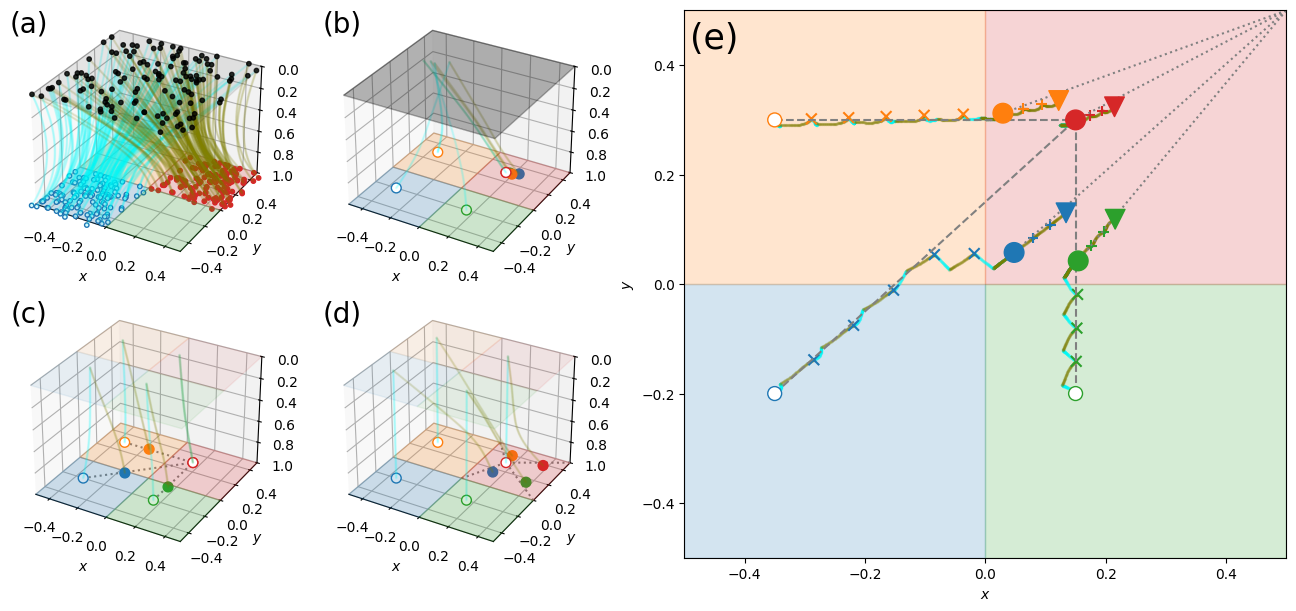

In [19]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(traj_r_list)]
bg_center_list = [(-.5, -.5), (-.5, 0.), (0, -.5), (0., 0.)]

fig = plt.figure(constrained_layout=True, figsize=(13,6))
gs = fig.add_gridspec(2, 4)
ax1 = plt.subplot(gs[0, 0], projection='3d')
ax2 = plt.subplot(gs[0, 1], projection='3d')
ax3 = plt.subplot(gs[1, 0], projection='3d')
ax4 = plt.subplot(gs[1, 1], projection='3d')
ax5 = plt.subplot(gs[0:, 2:])

plot_trajectories1(traj_r_list, colors = color_list, bg_centers = bg_center_list, lifting_traj = 0, landing_traj = 3, n = 128, ax = ax1)
plot_trajectories2(traj_lift_list1, traj_land_list1, colors = color_list, bg_centers = bg_center_list, ax = ax2)


plot_trajectories3(traj_lift_list3, traj_land_list3, colors = color_list, bg_centers = bg_center_list, z_lower=t_lower3, 
                   target_points = traj_lift_list3[0][0], ax = ax3)
plot_trajectories3(traj_lift_list2, traj_land_list2, colors = color_list, bg_centers = bg_center_list, z_lower=t_lower2, 
                   target_points = torch.tensor([[0.,0.], [0., 0.5], [0.5, 0.], [0.5, 0.5]]), ax = ax4)


plot_trajectories4(traj_lift_list, traj_land_list, colors = color_list, bg_centers = bg_center_list, z_lower=t_lower, 
                   target_points = traj_lift_list3[0][0], target_points2 = torch.tensor([[0.5, 0.5]]), ax = ax5)
plot_trajectories5(traj_lift_list_robust, traj_land_list_robust, colors = color_list, bg_centers = bg_center_list, ax = ax5)

ax1.text2D(0.05, 0.95, "(a)", fontsize=20,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes)
ax2.text2D(0.05, 0.95, '(b)', fontsize=20,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes)
ax3.text2D(0.05, 0.95, '(c)', fontsize=20,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes)
ax4.text2D(0.05, 0.95, '(d)', fontsize=20,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes)
ax5.text(0.05, 0.95, '(e)', fontsize=25,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes)
# plt.close(fig)

In [ ]:
# fig.savefig('final_demo.png', dpi = 400, bbox_inches='tight')